In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import os
%matplotlib inline
path = os.getcwd().split('/')

machine_path = '/' + path[1] + '/' + path[2]

plt.style.use(machine_path+'/opt/scripts/des.mplstyle')

(301, 1601) 1335.9045025739872
(301, 1601) 1385.3824471137646


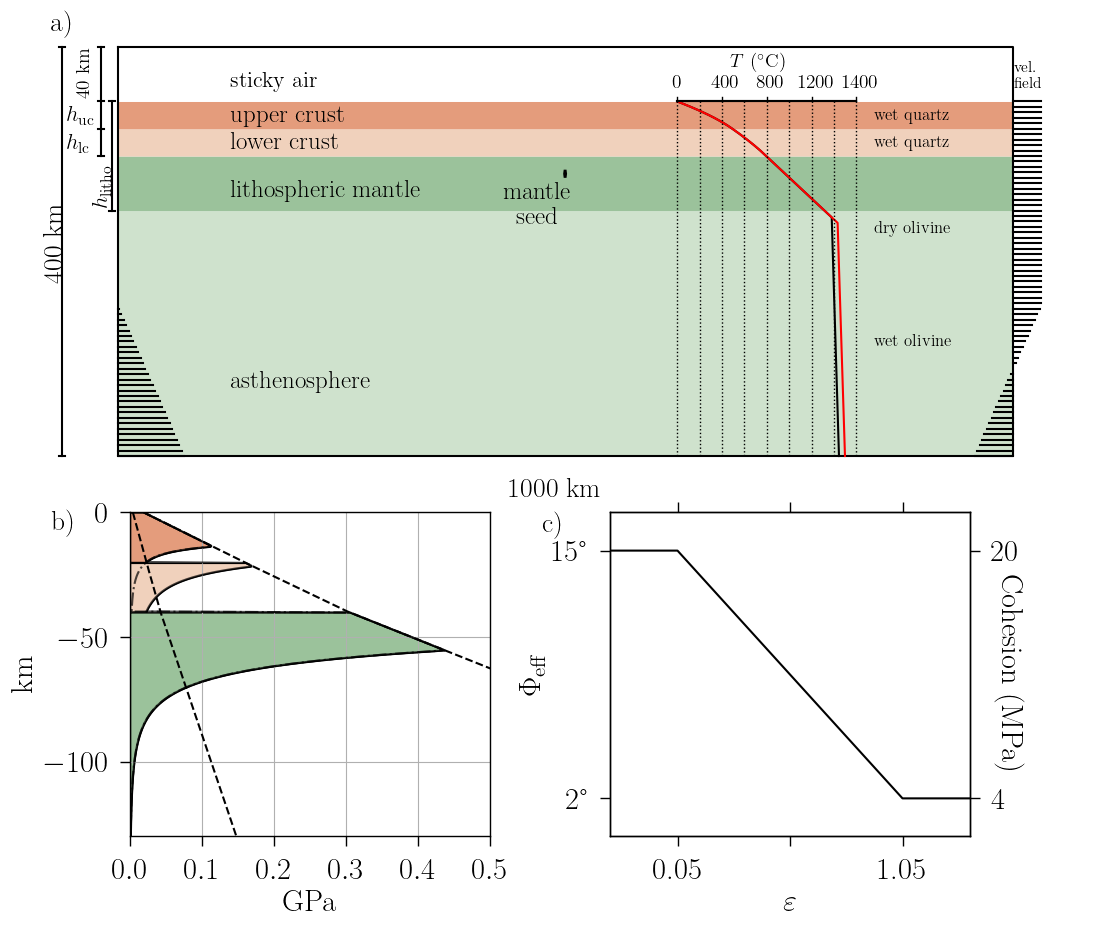

In [4]:
# total model horizontal extent (m)
Lx = 1600 * 1.0e3

# total model vertical extent (m)
Lz = 300 * 1.0e3

# number of points in horizontal direction
Nx = 1601

# number of points in vertical direction
Nz = 301

# thickness of sticky air layer (m)
H_sa = 40 * 1.0e3

# thickness of lower crust (m)
H_lower_crust = 20 * 1.0e3

# thickness of upper crust (m)
H_upper_crust = 20 * 1.0e3

# depth for the center of seed
D_seed_uc = 10.0E3

# total thickness of lithosphere (m)
H_litho = 80 * 1.0e3#130 * 1.0e3

# seed depth bellow base of lower crust (m)
seed_depth = 13 * 1.0e3

x = np.linspace(0, Lx, Nx)
z = np.linspace(Lz, 0, Nz)
X, Z = np.meshgrid(x, z)

##############################################################################
# Interfaces (bottom first)
##############################################################################
interfaces = {
    "litho": np.ones(Nx) * (H_litho + H_sa),
    "seed_base": np.ones(Nx) * (seed_depth + H_lower_crust + H_upper_crust + H_sa),
    "seed_top": np.ones(Nx) * (seed_depth + H_lower_crust + H_upper_crust + H_sa),
    "lower_crust": np.ones(Nx) * (H_lower_crust + H_upper_crust + H_sa),
    "upper_crust": np.ones(Nx) * (H_upper_crust + H_sa),
    "air": np.ones(Nx) * (H_sa),
}

# seed thickness (m)
H_seed = 6 * 1.0e3
# seed horizontal position (m)
x_seed = 800 * 1.0e3
# seed: number of points of horizontal extent
n_seed = 6

interfaces['seed_base'][int(Nx*x_seed//Lx - n_seed//2):int(Nx*x_seed//Lx + n_seed//2)] = interfaces['seed_base'][int(Nx*x_seed//Lx - n_seed//2):int(Nx*x_seed//Lx + n_seed//2)] + H_seed//2
interfaces['seed_top'][int(Nx*x_seed//Lx - n_seed//2):int(Nx*x_seed//Lx + n_seed//2)] = interfaces['seed_top'][int(Nx*x_seed//Lx - n_seed//2):int(Nx*x_seed//Lx + n_seed//2)] - H_seed//2


Huc = 2.5E-6/2700.0#old 9.2e-10
Hlc = 0.8E-6/2800.0#old 2.9e-10

##############################################################################
# Configuracao termica inicial
##############################################################################


Tps = [1350, 1400]
Tzs = []

for Tp in Tps:
    T = 1300 * (z - H_sa) / (H_litho) # Temperatura

    Ta = (Tp / np.exp(-10 * 3.28E-5 * (z - H_sa) / 1250))

    T[T < 0.0] = 0.0
    cond1 = Ta<T #VICTOR
    T[T > Ta] = Ta[T > Ta]

    kappa = 1.0e-6

    ccapacity = 1250

    H = np.zeros_like(T)

    cond = (z >= H_sa) & (z < H_upper_crust + H_sa) # upper crust
    H[cond] = Huc

    cond = (z >= H_upper_crust + H_sa) & (z < H_lower_crust + H_upper_crust + H_sa) # lower crust
    H[cond] = Hlc

    Taux = np.copy(T)
    t = 0
    dt = 5000
    dt_sec = dt * 365 * 24 * 3600
    #cond = (z>H_sa+H_litho) | (T == 0) #(T > 1300) | (T == 0) #OLD
    cond = cond1 | (T == 0)#VICTOR
    dz = Lz / (Nz - 1)

    while t < 500.0e6:
        T[1:-1] += kappa*dt_sec*((T[2:]+T[:-2]-2*T[1:-1])/dz**2) + H[1:-1]*dt_sec/ccapacity
        T[cond] = Taux[cond]
        t = t + dt

    Tz = np.copy(T)

    T = np.ones_like(X) * T[:, None]

    Tzs.append(Tz)
    print(np.shape(T), Ta[-1])



##############################################################################
# Configuracao velocidade inicial
##############################################################################

fac_air = 10.0e3

# 1 cm/ano
vL = 0.005 / (365 * 24 * 3600) # m/s

h_v_const = 150.0e3 # espessura com velocidade constante
ha = Lz - H_sa - h_v_const # diferenca

vR = 2 * vL * (h_v_const + ha) / ha # garante que integral seja zero

VX = np.zeros_like(X)
cond = (Z > h_v_const + H_sa) & (X == 0)
VX[cond] = vR * (Z[cond] - h_v_const - H_sa) / ha

cond = (Z > h_v_const + H_sa) & (X == Lx)
VX[cond] = -vR * (Z[cond] - h_v_const - H_sa) / ha

cond = X == Lx
VX[cond] += +2 * vL

cond = Z <= H_sa - fac_air
VX[cond] = 0

# print(np.sum(VX))

v0 = VX[(X == 0)]
vf = VX[(X == Lx)]
sv0 = np.sum(v0[1:-1]) + (v0[0] + v0[-1]) / 2.0
svf = np.sum(vf[1:-1]) + (vf[0] + vf[-1]) / 2.0
# print(sv0, svf, svf - sv0)

diff = (svf - sv0) * dz

vv = -diff / Lx
# print(vv, diff, svf, sv0, dz, Lx)

VZ = np.zeros_like(X)

cond = Z == 0
VZ[cond] = vv

# print(np.sum(v0))
# print(np.sum(vf))
# print(np.sum(vf)-np.sum(v0))

VVX = np.copy(np.reshape(VX, Nx*Nz))
VVZ = np.copy(np.reshape(VZ, Nx*Nz))

v = np.zeros((2, Nx*Nz))

v[0, :] = VVX
v[1, :] = VVZ

v = np.reshape(v.T, (np.size(v)))


###############################################
# Configuracao exp de precipitacao
###############################################
# prec = 0.0008*np.exp(-(x-Lx/2)**6/(Lx/(8*1))**6) #exp 200 km: original
prec = 0.0008*np.exp(-(x-Lx/2)**6/(Lx/(8*2))**6) #exp 100 km
prec1 = 0.0008*np.exp(-(x-Lx/2)**6/(Lx/(8*4))**6) #exp 50 km

##############################################################################
# CREATING NUMERICAL SETUP FIGURE
##############################################################################

plt.close()

fig = plt.figure(figsize=(12,9)) #controle

b1 = [0.05,
      0.5,
      0.9,
      0.5]
bv1 = plt.axes(b1)

b2 = [0.15+0*0.4,
      0.1,
      0.3,
      0.36]
bv2 = plt.axes(b2)

b3 = [0.15+1*0.4,
      0.1, #ymin
      0.3,
      0.36]#ymax

bv3 = plt.axes(b3)
bv3t = bv3.twinx()

##############################################################################
# Plot a) Layers, seed, veloc field and precipitation profile
##############################################################################

#box domain contour
bv1.plot([0,0,Lx/1000,Lx/1000,0],[0,-Lz/1000,-Lz/1000,0,0],"k")


#layers colour scheme
cr = 255.
color_uc = (228./cr,156./cr,124./cr)
color_lc = (240./cr,209./cr,188./cr)
color_lit = (155./cr,194./cr,155./cr)
color_ast = (207./cr,226./cr,205./cr)

#paint layers
a1 = interfaces["litho"]
a2 = a1*0+300.0E3
bv1.fill_between(x/1000,-a1/1000,-a2/1000,fc=color_ast,ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces["lower_crust"]
bv1.fill_between(x/1000,-a1/1000,-a2/1000,fc=color_lit,ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces["upper_crust"]
bv1.fill_between(x/1000,-a1/1000,-a2/1000,fc=color_lc,ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces["air"]
bv1.fill_between(x/1000,-a1/1000,-a2/1000,fc=color_uc,ec="face",lw=0.0)


a2 = interfaces["seed_base"]
a1 = interfaces["seed_top"]
aa1 = np.copy(a1)
aa1[1:-1] += 0.2*(aa1[2:]-2*aa1[1:-1]+aa1[:-2])
cond = aa1!=a2
pa1 = a1[cond]
pa2 = a2[cond]
px = x[cond]
bv1.fill_between(px/1000,-pa1/1000,-pa2/1000,fc=(0,0,0),lw=0.0)

fsize=16
##############################################################################
# Plot temperature field
##############################################################################

colors_Tz = ['k', 'r']

for Tz, color in zip(Tzs, colors_Tz):
    Tscale = 0.2
    Tshift = 1000.0

    cT = z>=40000.0
    bv1.plot(Tz[cT]*Tscale+Tshift,-(z[cT]/1000),color=color, alpha=1)

    bv1.plot([Tshift,Tshift+1600*Tscale],[-40,-40],color='k')


for Ti in np.arange(0,1601,200):
    bv1.plot([Tshift+Ti*Tscale,Tshift+Ti*Tscale],[-40,-300],"k:",lw=1.0)

for Ti in np.arange(0,1601,400):
    bv1.plot([Tshift+Ti*Tscale,Tshift+Ti*Tscale],[-40,-37],"k",lw=1.0)

bv1.text(Tshift + 0*Tscale-10, -30, "0", fontsize=fsize-2)
bv1.text(Tshift + 400*Tscale - 20, -30, "400", fontsize=fsize-2)
bv1.text(Tshift + 800*Tscale - 20, -30, "800", fontsize=fsize-2)
bv1.text(Tshift + 1200*Tscale - 25, -30, "1200", fontsize=fsize-2)
bv1.text(Tshift + 1600*Tscale - 25, -30, "1400", fontsize=fsize-2)
bv1.text(Tshift + 600*Tscale - 25, -15, "$T$ ($^\circ$C)", fontsize=fsize-2)


##############################################################################
# Plot veloc field
##############################################################################

scale_veloc = 5000*365.*24.*3600.
for i in range(0,np.size(z)-40,4):
    if VX[i,0]!=0.0:
        bv1.plot([scale_veloc*VX[i, 0],0], [-z[i]/1000,-z[i]/1000],"k")

for i in range(0,np.size(z)-40,4):
    bv1.plot([scale_veloc*VX[i, -1]+Lx/1000,Lx/1000], [-z[i]/1000,-z[i]/1000],"k")


bv1.text(1602,-30,"vel.\nfield",fontsize=fsize-5)


##############################################################################
# Set Plot a) details
##############################################################################
bv1.axis('off')
#naming layers
fsize=16
bv1.text(200,-30,"sticky air", fontsize=fsize)
bv1.text(200,-40-15,"upper crust", fontsize=fsize+2)
bv1.text(200,-40-35,"lower crust", fontsize=fsize+2)
bv1.text(200,-110,"lithospheric mantle", fontsize=fsize+2)
bv1.text(200,-250,"asthenosphere", fontsize=fsize+2)

bv1.text(750,-130,"mantle\nseed",ha="center", fontsize=fsize+2)

dx = 5
displx = -30

bv1.plot([-100,-100],[0,-Lz/1000],"k")
bv1.plot([-100-dx,-100+dx],[0,0],"k")
bv1.plot([-100-dx,-100+dx],[-Lz/1000,-Lz/1000],"k")

tickx = [displx-dx,displx+dx]
bv1.plot([displx,displx],[0,-80],"k")
bv1.plot(tickx,[0,0],"k")
bv1.plot(tickx,[-40,-40],"k")
bv1.plot(tickx,[-60,-60],"k")
bv1.plot(tickx,[-80,-80],"k")

#Layers thickness

bv1.text(-45+displx,-35,"40 km", fontsize=fsize-2, rotation=90)

bv1.text(-60+displx,-55, r"$h_{\mathrm{uc}}$", fontsize=fsize)
bv1.text(-60+displx,-75, r"$h_{\mathrm{lc}}$", fontsize=fsize)

#hlines of layer thickness vlines
bv1.plot([-10,-10],[-40,-80-40],"k") #hlit
bv1.plot([-10-dx,-10+dx],[-40,-40],"k")#huc
bv1.plot([-10-dx,-10+dx],[-80-40,-80-40],"k")

bv1.text(-46,-115,r"$h_{\mathrm{litho}}$", fontsize=fsize, rotation=90)

#Lz and Lx
bv1.text(-135,-170,"400 km",rotation=90, fontsize=fsize+4)
bv1.text(Lx/1000/2-100,-Lz/1000-30,"1000 km", fontsize=fsize+4)

bv1.text(0.8, 0.80, 'wet quartz', color='k', fontsize=12,
        horizontalalignment='left', verticalalignment='center',
        transform=bv1.transAxes)
bv1.text(0.8, 0.74, 'wet quartz', color='k', fontsize=12,
        horizontalalignment='left', verticalalignment='center',
        transform=bv1.transAxes)
bv1.text(0.8, 0.55, 'dry olivine', color='k', fontsize=12,
        horizontalalignment='left', verticalalignment='center',
        transform=bv1.transAxes)
bv1.text(0.8, 0.30, 'wet olivine', color='k', fontsize=12,
        horizontalalignment='left', verticalalignment='center',
        transform=bv1.transAxes)
#Precipitation profile
# dz = 3

# bv1.plot([0,Lx/1000],[-Lz/1000-40,-Lz/1000-40],"k")
# bv1.plot([0,0],[-Lz/1000-40-dz,-Lz/1000-40+dz],"k")
# bv1.plot([Lx/1000,Lx/1000],[-Lz/1000-40-dz,-Lz/1000-40+dz],"k")

# maxprec = np.max(prec)*40000
# bv1.plot(x/1000,prec*40000 + 15,"k")
# bv1.plot(x/1000,prec*0 + 15,"k",lw=0.6)
# bv1.plot(x/1000,maxprec +x*0 + 15,"k:",lw=0.6)
# bv1.plot([0,0],[maxprec+15,15],"k",lw=0.6)

# maxprec1 = np.max(prec1)*40000 #contr
# bv1.plot(x/1000,prec1*40000 + 15,"k", alpha=0.6)
# bv1.plot(x/1000,prec1*0 + 15,"k",lw=0.6)
# bv1.plot(x/1000,maxprec1 +x*0 + 15,"k:",lw=0.6)
# bv1.plot([0,0],[maxprec1+15,15],"k",lw=0.6)

# bv1.text(-58,15-2,"0.0",size=14)
# bv1.text(-58,maxprec+15-2,"1.0",size=14)

# bv1.text(-60,30,r"$e_f$",fontsize=fsize)

bv1.text(-120,12,r"a)",size=20)

##############################################################################
# Plot b: YSE and c: YSE
##############################################################################

L = 130.0E3
N = 361
z = np.linspace(0,L,N)
dz = z[1]-z[0]

rho = np.zeros_like(z)
uc = z<=20.0E3
lc = (z>20.0E3)&(z<=40.0E3)
lm = (z>40.0E3)



rho[uc]=2700.0
rho[lc]=2800.0
rho[lm]=3354.0
g = 10.0

P = 0.0
Paux = 0.0
for i in range(1,N):
    Paux += dz*rho[i]*g
    P = np.append(P,Paux)

#plt.plot(P/1.0E9,-z/1000)

phi = 2.0*np.pi/180.0
c0 = 4.0E6
sigma_min = c0 * np.cos(phi) + P * np.sin(phi)
#plt.plot(sigma/1.0E9,-z/1000)

phi = 15.0*np.pi/180.0
c0 = 20.0E6
sigma_max = c0 * np.cos(phi) + P * np.sin(phi)
#plt.plot(sigma/1.0E9,-z/1000)

##############################################################################
# Creating subplot b)
##############################################################################

bv2.text(-0.11,-7,"b)",size=20)

#rheological params
Q = np.zeros_like(z)
A = np.zeros_like(z)
n = np.zeros_like(z)
V = np.zeros_like(z)
C = np.zeros_like(z)

Q[uc]=222000.0
Q[lc]=222000.0
Q[lm]=540000.0

A[uc]=8.574E-28
A[lc]=8.574E-28
A[lm]=2.4168E-15

n[uc]=4.0
n[lc]=4.0
n[lm]=3.5

V[uc]=0.0
V[lc]=0.0
V[lm]=25.0E-6

T = 1300 * z / L

kappa = 1.0e-6

ccapacity = 1250

H = np.zeros_like(z)
Huc = 2.5E-6/2700.0#old 9.2e-10
Hlc = 0.8E-6/2800.0#old 2.9e-10

H[uc] = Huc
H[lc] = Hlc

Taux = np.copy(T)
t = 0
dt = 1000
dt_sec = dt * 365 * 24 * 3600

while t < 500.0e6:
    T[1:-1] += kappa*dt_sec*((T[2:]+T[:-2]-2*T[1:-1])/dz**2) + H[1:-1]*dt_sec/ccapacity
    t = t + dt

#plt.plot(T,-z/1000)

#strain rate (sr)
sr = 1.0E-15

#gas constant
R = 8.314

#print(n)

#Temperature Kelvin
TK = T + 273

#Viscosity
#Choosing C for layers
C[uc]=1.0

# Cslc = [1,2,5,10,40]
Cslc = [1, 10]
#C[lc]=clc
C[lm]=1.0

# colors =['#e41a1c', #fire engine red
#          '#377eb8', #curious blue
#          '#4daf4a', #green - Faux Apple
#          '#984ea3', #violet blue
#          'black'] #dark orange #['xkcd:cerulean blue', 'xkcd:scarlet', 'xkcd:dark green']
colors = ['black','black']
lines = ['-.', '-']

for clc, color, line in zip(Cslc, colors, lines):
    C[lc] = clc
    visc = C * A**(-1./n) * sr**((1.0-n)/n)*np.exp((Q + V*P)/(n*R*TK))

    sigma_v = visc * sr

    cond = sigma_v>sigma_max
    sigma_v[cond]=sigma_max[cond]
    bv2.plot(sigma_v/1.0E9,-z/1000, linestyle=line, color=color, alpha=0.7)

    if clc==Cslc[-1]:
        cr = 255.
        color_uc = (228./cr, 156./cr, 124./cr)
        color_lc = (240./cr, 209./cr, 188./cr)
        color_lit = (155./cr, 194./cr, 155./cr)
        color_ast = (207./cr, 226./cr, 205./cr)

        #filling inside YSE
        bv2.fill_betweenx(-z[uc]/1000,z[uc]*0,sigma_v[uc]/1.0E9,color=color_uc,ec="k")
        bv2.fill_betweenx(-z[lc]/1000,z[lc]*0,sigma_v[lc]/1.0E9,color=color_lc,ec="k")
        bv2.fill_betweenx(-z[lm]/1000,z[lm]*0,sigma_v[lm]/1.0E9,color=color_lit,ec="k")

        gray=0.
        bv2.plot(sigma_min/1.0E9,-z/1000,"--",color=(gray,gray,gray))
        bv2.plot(sigma_max/1.0E9,-z/1000,"--",color=(gray,gray,gray))
        
#         xpos_C_label=0.75
#         bv2.text(xpos_C_label, 0.37, '$C_{\mathrm{lc}} = 1$', color='#e41a1c', fontsize=18,
#                horizontalalignment='left', verticalalignment='center',
#                transform=bv2.transAxes)
#         bv2.text(xpos_C_label, 0.29, '$C_{\mathrm{lc}} = 2$', color='#377eb8', fontsize=18,
#                    horizontalalignment='left', verticalalignment='center',
#                    transform=bv2.transAxes)
#         bv2.text(xpos_C_label, 0.21, '$C_{\mathrm{lc}} = 5$', color='#4daf4a', fontsize=18,
#                    horizontalalignment='left', verticalalignment='center',
#                    transform=bv2.transAxes)
#         bv2.text(xpos_C_label, 0.13, '$C_{\mathrm{lc}} = 10$', color='#984ea3', fontsize=18,
#                    horizontalalignment='left', verticalalignment='center',
#                    transform=bv2.transAxes)
#         bv2.text(xpos_C_label, 0.05, '$C_{\mathrm{lc}} = 40$', color='black', fontsize=18,
#                    horizontalalignment='left', verticalalignment='center',
#                    transform=bv2.transAxes)
label_size=22
plt.rc('xtick', labelsize=label_size)
plt.rc('ytick', labelsize=label_size)

bv2.set_xlim(0, 0.5)
bv2.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
bv2.set_ylim(-130, 0)
bv2.set_xlabel("GPa", fontsize=label_size)

if i==1:
    #bv1.set_yticklabels([])	
    bv2.set_ylabel("km", fontsize=label_size)
#     plt.title("coupled lithosphere")
else:
#     plt.title("strain rate: $10^{-15}$ s$^{-1}$")
    bv2.set_ylabel("km", fontsize=label_size)

bv2.grid('k')

##############################################################################
# Creating subplot c)
##############################################################################
label_size=22

plt.rc('xtick', labelsize=label_size)
plt.rc('ytick', labelsize=label_size)

bv3.text(-0.05, 16, "c)", size=20)

# xdata = np.array([0, 0.05, 1.05, 1.1])
xdata = np.array([0, 0.25, 0.75, 1.0])
ydata = np.array([15, 15, 2, 2])

bv3.plot(xdata, ydata, 'k-')

bv3.set_xlim([0.10, 0.9])
bv3.set_ylim([0, 17])
bv3.set_xticks([0.25, 0.5, 0.75])
bv3.set_xticklabels([0.05, ' ', 1.05])
bv3.tick_params('x', top=True, labeltop=False)
bv3.set_xlabel(r"$\varepsilon$", fontsize=label_size)

bv3.set_yticks([2, 15])
bv3.set_yticklabels(['2°', '15°'])
bv3.set_ylabel('$\Phi_{\mathrm{eff}}$', fontsize=label_size)

# bv3t = bv3.twinx()
bv3t.set_ylim([0, 17])
bv3t.set_yticks([2, 15])
bv3t.set_yticklabels([4, 20])
bv3t.set_ylabel('Cohesion (MPa)', fontsize=label_size, rotation=270)

fig.savefig('out/' + "NumSetup_Doc_RFT_ACC.pdf", dpi=400, bbox_inches='tight')
fig.savefig('out/' + "NumSetup_Doc_RFT_ACC.png", dpi=400, bbox_inches='tight')